<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Bubble Plots**


Estimated time needed: **30** minutes


In this lab, you will focus on visualizing data.

The dataset will be directly loaded into pandas for analysis and visualization.

You will use various visualization techniques to explore the data and uncover key trends.


## Objectives


In this lab, you will perform the following:


-   Visualize the distribution of data.

-   Visualize the relationship between two data features.

-   Visualize composition of data.

-   Visualize comparison of data.


#### Setup: Working with the Database
**Install and import the needed libraries**


In [1]:
!pip install pandas 
!pip install matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re


**Download and connect to the database file containing survey data.**


To start, download and load the dataset into a `pandas` DataFrame.



In [2]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/n01PQ9pSmiRX6520flujwQ/survey-data.csv"

# Read straight from the URL
df = pd.read_csv(url)

# Quick checks
print(df.shape)       # (rows, cols)
print(df.columns[:10])
df.head()

(65437, 114)
Index(['ResponseId', 'MainBranch', 'Age', 'Employment', 'RemoteWork', 'Check',
       'CodingActivities', 'EdLevel', 'LearnCode', 'LearnCodeOnline'],
      dtype='object')


,ResponseId,MainBranch,Age,Employment,RemoteWork,Check,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,...,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,SurveyLength,SurveyEase,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,Under 18 years old,"Employed, full-time",Remote,Apples,Hobby,Primary/elementary school,Books / Physical media,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,3,I am a developer by profession,45-54 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Easy,NaN,NaN
3,4,I am learning to code,18-24 years old,"Student, full-time",NaN,Apples,NaN,Some college/university study without earning ...,"Other online resources (e.g., videos, blogs, f...",Stack Overflow;How-to videos;Interactive tutorial,...,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Easy,NaN,NaN
4,5,I am a developer by profession,18-24 years old,"Student, full-time",NaN,Apples,NaN,"Secondary school (e.g. American high school, G...","Other online resources (e.g., videos, blogs, f...",Technical documentation;Blogs;Written Tutorial...,...,NaN,NaN,NaN,NaN,NaN,NaN,Too short,Easy,NaN,NaN


### Task 1: Exploring Data Distributions Using Bubble Plots


#### 1. Bubble Plot for Age vs. Frequency of Participation


- Visualize the relationship between respondents’ age and their participation frequency (`SOPartFreq`) using a bubble plot.

- Use the size of the bubbles to represent their job satisfaction (`JobSat`).


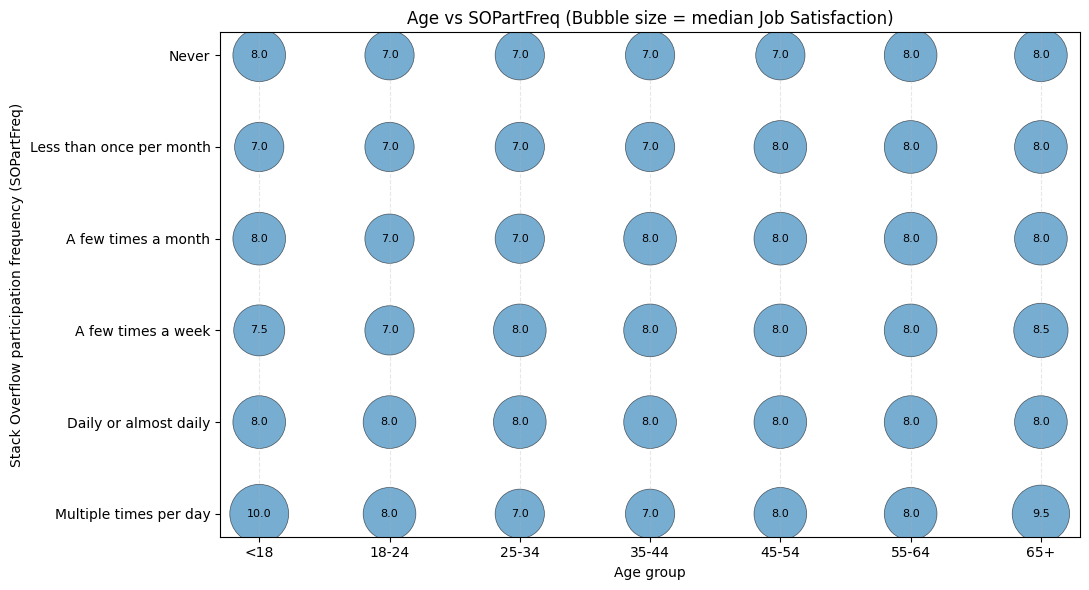

In [3]:
# --- 2) Helpers to clean/map values ---

def parse_age_to_number(x):
    """
    Convert Age values to a numeric age (years).
    Handles numeric strings, ranges like '18-24 years old',
    'Under 18 years old', '65 years or older', etc.
    """
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()

    # Direct numeric (e.g., '32')
    num = pd.to_numeric(s, errors="coerce")
    if not np.isnan(num):
        return float(num)

    # Range like '18-24', '25–34'
    m = re.search(r'(\d+)\D+(\d+)', s)
    if m:
        a, b = float(m.group(1)), float(m.group(2))
        return (a + b) / 2.0

    # 'under 18'
    if "under" in s and re.search(r'\b18\b', s):
        return 16.0  # a reasonable midpoint proxy

    # '65 years or older'
    if ("65" in s and "older" in s) or "65+" in s:
        return 67.0  # small buffer above 65

    # Fallback: not parseable
    return np.nan


def map_participation_freq(x):
    """
    Map SOPartFreq text to ordered categories.
    We’ll return a canonical label so we can order it later.
    """
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()

    if "multiple times per day" in s:
        return "Multiple times per day"
    if "daily" in s:  # 'Daily or almost daily'
        return "Daily or almost daily"
    if "few times a week" in s or "times per week" in s:
        return "A few times a week"
    if "few times a month" in s or "times per month" in s:
        return "A few times a month"
    if "less than once per month" in s or "less than once a month" in s:
        return "Less than once per month"
    if "never" in s or ("do not" in s and "participate" in s):
        return "Never"
    # Fallback if phrasing differs slightly; bucket to 'A few times a month'
    return "A few times a month"


def map_job_satisfaction(x):
    """
    Convert JobSat to a numeric scale if needed.
    First try numeric (e.g., '7', '8'), otherwise map common Likert terms:
      Very satisfied=5, Slightly satisfied=4, Neither=3,
      Slightly dissatisfied=2, Very dissatisfied=1
    """
    if pd.isna(x):
        return np.nan

    # Try direct numeric first
    val = pd.to_numeric(x, errors="coerce")
    if not np.isnan(val):
        return float(val)

    s = str(x).strip().lower()
    if s.startswith("very sat"):
        return 5.0
    if s.startswith("slightly sat"):
        return 4.0
    if "neither" in s:
        return 3.0
    if s.startswith("slightly dis"):
        return 2.0
    if s.startswith("very dis"):
        return 1.0

    # Fallback
    return np.nan

# --- 3) Prepare columns ---

# Age -> numeric
df["Age_num"] = df["Age"].apply(parse_age_to_number) if "Age" in df.columns else np.nan

# SOPartFreq -> canonical category labels
if "SOPartFreq" in df.columns:
    df["SOPartFreq_cat"] = df["SOPartFreq"].apply(map_participation_freq)
else:
    raise KeyError("Column 'SOPartFreq' not found in the dataset.")

# JobSat -> numeric
if "JobSat" in df.columns:
    # Attempt numeric, then fallback to mapping for strings
    jobsat_num = pd.to_numeric(df["JobSat"], errors="coerce")
    jobsat_map = df["JobSat"].apply(map_job_satisfaction)
    df["JobSat_num"] = jobsat_num.fillna(jobsat_map)
else:
    raise KeyError("Column 'JobSat' not found in the dataset.")

# Drop rows missing any required fields
plot_df = df.dropna(subset=["Age_num", "SOPartFreq_cat", "JobSat_num"]).copy()

# Optional: Bin ages for a cleaner bubble plot (you can remove if you prefer raw ages)
age_bins = [0, 18, 25, 35, 45, 55, 65, 120]
age_labels = ["<18", "18-24", "25-34", "35-44", "45-54", "55-64", "65+"]
plot_df["AgeGroup"] = pd.cut(plot_df["Age_num"], bins=age_bins, labels=age_labels, right=False, include_lowest=True)

# Order the participation frequency axis
freq_order = [
    "Multiple times per day",
    "Daily or almost daily",
    "A few times a week",
    "A few times a month",
    "Less than once per month",
    "Never",
]
plot_df["SOPartFreq_cat"] = pd.Categorical(plot_df["SOPartFreq_cat"], categories=freq_order, ordered=True)

# --- 4) Aggregate for bubble sizes (median JobSat per AgeGroup x SOPartFreq) ---
agg = (
    plot_df.groupby(["AgeGroup", "SOPartFreq_cat"], observed=True)
           .agg(median_jobsat=("JobSat_num", "median"))
           .reset_index()
)

# Convert categories to axis positions
agg["x"] = agg["AgeGroup"].cat.codes
agg["y"] = agg["SOPartFreq_cat"].cat.codes

# Bubble size scaling (adjust factor if bubbles feel too small/large)
size_scale = 180.0
agg["bubble_size"] = agg["median_jobsat"] * size_scale

# --- 5) Plot: Bubble chart ---
plt.figure(figsize=(11, 6))
sc = plt.scatter(
    agg["x"], agg["y"],
    s=agg["bubble_size"],
    alpha=0.6,
    edgecolors="black",
    linewidths=0.5
)

# Axes & ticks
plt.xticks(ticks=range(len(age_labels)), labels=age_labels, rotation=0)
plt.yticks(ticks=range(len(freq_order)), labels=freq_order)
plt.xlabel("Age group")
plt.ylabel("Stack Overflow participation frequency (SOPartFreq)")
plt.title("Age vs SOPartFreq (Bubble size = median Job Satisfaction)")

# Optional: annotate bubbles with median JobSat values (rounded)
for _, row in agg.iterrows():
    if not np.isnan(row["median_jobsat"]):
        plt.text(row["x"], row["y"], f'{row["median_jobsat"]:.1f}',
                 ha="center", va="center", fontsize=8)

plt.grid(True, axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# --- Notes ---
# • If you prefer raw ages on the x-axis (no bins), replace "AgeGroup" with "Age_num"
#   and set x ticks via something like plt.xlabel("Age (years)") without categorical codes.
# • If your dataset already stores JobSat as 1–10, the mapping will still work (numeric wins).


#### 2. Bubble Plot for Compensation vs. Job Satisfaction


-Visualize the relationship between yearly compensation (`ConvertedCompYearly`) and job satisfaction (`JobSat`).

- Use the size of the bubbles to represent respondents’ age.


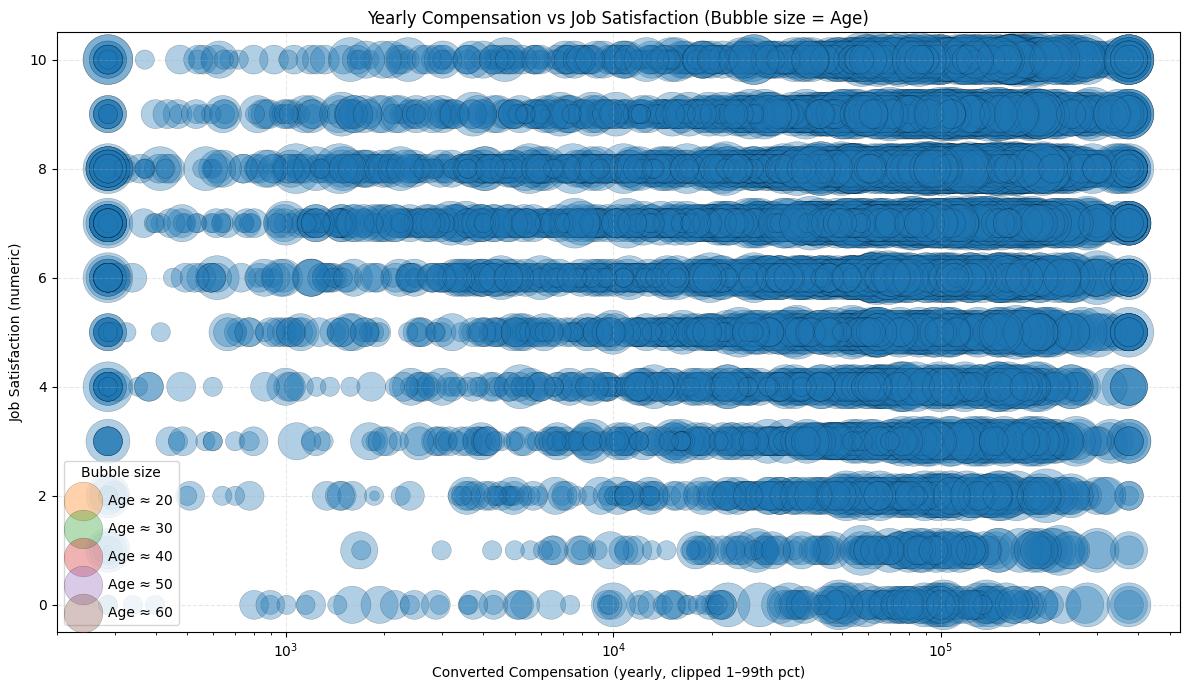

In [4]:


# --- 2) Helpers to clean/map values ---

def parse_age_to_number(x):
    """
    Convert Age values to a numeric age (years).
    Handles numeric strings, ranges like '18-24 years old',
    'Under 18 years old', '65 years or older', etc.
    """
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()

    # Direct numeric (e.g., '32')
    num = pd.to_numeric(s, errors="coerce")
    if not np.isnan(num):
        return float(num)

    # Range like '18-24', '25–34'
    m = re.search(r'(\d+)\D+(\d+)', s)
    if m:
        a, b = float(m.group(1)), float(m.group(2))
        return (a + b) / 2.0

    # 'under 18'
    if "under" in s and re.search(r'\b18\b', s):
        return 16.0  # midpoint proxy

    # '65 years or older'
    if ("65" in s and "older" in s) or "65+" in s:
        return 67.0

    return np.nan


def map_job_satisfaction(x):
    """
    Convert JobSat to numeric.
    - Use numeric if present (e.g., 1–5 or 1–10).
    - Otherwise map common Likert terms to 1–5.
    """
    if pd.isna(x):
        return np.nan

    # Try direct numeric first
    val = pd.to_numeric(x, errors="coerce")
    if not np.isnan(val):
        return float(val)

    s = str(x).strip().lower()
    if s.startswith("very sat"):
        return 5.0
    if s.startswith("slightly sat"):
        return 4.0
    if "neither" in s:
        return 3.0
    if s.startswith("slightly dis"):
        return 2.0
    if s.startswith("very dis"):
        return 1.0

    return np.nan


def scale_sizes(series, min_size=50, max_size=1500):
    """
    Scale a numeric series to marker areas between min_size and max_size (points^2).
    """
    s = series.astype(float)
    s = s.replace([np.inf, -np.inf], np.nan)
    lo, hi = s.min(), s.max()
    if pd.isna(lo) or pd.isna(hi) or lo == hi:
        return pd.Series(np.full(len(s), (min_size + max_size) / 2.0), index=s.index)
    return min_size + (s - lo) * (max_size - min_size) / (hi - lo)

# --- 3) Prepare required columns ---

# Age -> numeric
if "Age" not in df.columns:
    raise KeyError("Column 'Age' not found in the dataset.")
df["Age_num"] = df["Age"].apply(parse_age_to_number)

# JobSat -> numeric
if "JobSat" not in df.columns:
    raise KeyError("Column 'JobSat' not found in the dataset.")
jobsat_num = pd.to_numeric(df["JobSat"], errors="coerce")
jobsat_map = df["JobSat"].apply(map_job_satisfaction)
df["JobSat_num"] = jobsat_num.fillna(jobsat_map)

# Compensation -> numeric
if "ConvertedCompYearly" not in df.columns:
    raise KeyError("Column 'ConvertedCompYearly' not found in the dataset.")
df["Comp_num"] = pd.to_numeric(df["ConvertedCompYearly"], errors="coerce")

# Keep only valid rows
plot_df = df.dropna(subset=["Comp_num", "JobSat_num", "Age_num"]).copy()

# Remove non-sensical / extreme values (optional but helps visualization)
plot_df = plot_df[(plot_df["Comp_num"] > 0) & (plot_df["Age_num"] >= 10)]
# Clip compensation to 1st–99th percentile to reduce long-tail distortion
lo, hi = plot_df["Comp_num"].quantile([0.01, 0.99])
plot_df["Comp_num_clipped"] = plot_df["Comp_num"].clip(lower=lo, upper=hi)

# Bubble sizes from Age
plot_df["size"] = scale_sizes(plot_df["Age_num"], min_size=50, max_size=1500)

# --- 4) Plot: Bubble chart ---
plt.figure(figsize=(12, 7))
plt.scatter(
    plot_df["Comp_num_clipped"],
    plot_df["JobSat_num"],
    s=plot_df["size"],
    alpha=0.35,
    edgecolors="black",
    linewidths=0.3
)

# X-axis: log scale often helps for comp skew; turn off if you prefer linear
use_log_x = True
if use_log_x:
    plt.xscale("log")

plt.xlabel("Converted Compensation (yearly, clipped 1–99th pct)")
plt.ylabel("Job Satisfaction (numeric)")
plt.title("Yearly Compensation vs Job Satisfaction (Bubble size = Age)")

# Build a simple size legend with representative ages
for age_example in [20, 30, 40, 50, 60]:
    plt.scatter([], [], s=scale_sizes(pd.Series([age_example]), 50, 1500).iloc[0],
                label=f"Age ≈ {age_example}", alpha=0.35, edgecolors="black", linewidths=0.3)
plt.legend(scatterpoints=1, frameon=True, labelspacing=1.0, title="Bubble size")

plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


### Task 2: Analyzing Relationships Using Bubble Plots


#### 1. Bubble Plot of Technology Preferences by Age

- Visualize the popularity of programming languages respondents have worked with (`LanguageHaveWorkedWith`) across age groups.

- Use bubble size to represent the frequency of each language.



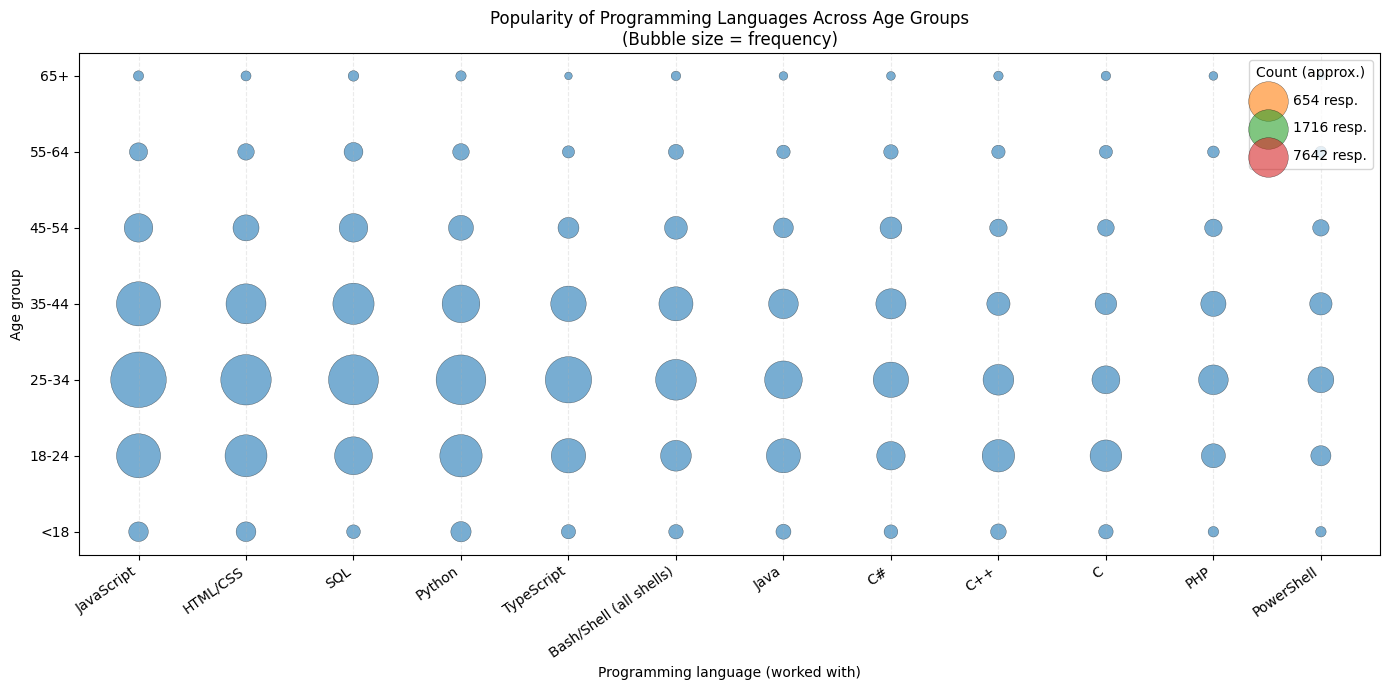

In [5]:

def parse_age_to_number(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().lower()
    # direct numeric
    v = pd.to_numeric(s, errors="coerce")
    if not pd.isna(v): return float(v)
    # ranges like '18-24 years old'
    m = re.search(r'(\d+)\D+(\d+)', s)
    if m:
        a, b = float(m.group(1)), float(m.group(2))
        return (a + b) / 2.0
    # 'under 18'
    if "under" in s and re.search(r'\b18\b', s): return 16.0
    # '65 years or older'
    if ("65" in s and "older" in s) or "65+" in s: return 67.0
    return np.nan

def scale_sizes(series, min_size=30, max_size=1600):
    s = pd.to_numeric(series, errors="coerce")
    s = s.replace([np.inf, -np.inf], np.nan)
    lo, hi = s.min(), s.max()
    if pd.isna(lo) or pd.isna(hi) or lo == hi:
        return pd.Series(np.full(len(s), (min_size + max_size) / 2.0), index=s.index)
    return min_size + (s - lo) * (max_size - min_size) / (hi - lo)

# --- Age bins ---
age_bins   = [0, 18, 25, 35, 45, 55, 65, 120]
age_labels = ["<18", "18-24", "25-34", "35-44", "45-54", "55-64", "65+"]

# --- Prepare Age groups ---
if "Age" not in df.columns:
    raise KeyError("Column 'Age' not found.")
df["Age_num"]   = df["Age"].apply(parse_age_to_number)
df["AgeGroup"]  = pd.cut(df["Age_num"], bins=age_bins, labels=age_labels, right=False, include_lowest=True)

# --- Prepare Language list (split & explode) ---
if "LanguageHaveWorkedWith" not in df.columns:
    raise KeyError("Column 'LanguageHaveWorkedWith' not found.")

lang_df = df[["LanguageHaveWorkedWith", "AgeGroup"]].dropna(subset=["LanguageHaveWorkedWith", "AgeGroup"]).copy()
# Split on ';' or ',' with optional spaces
lang_df["Language"] = lang_df["LanguageHaveWorkedWith"].str.split(r";\s*|,\s*")
lang_df = lang_df.explode("Language")
lang_df["Language"] = lang_df["Language"].str.strip()
lang_df = lang_df[lang_df["Language"].ne("")]

# --- Count frequencies by AgeGroup x Language ---
counts = (
    lang_df.groupby(["AgeGroup", "Language"], observed=True)
           .size()
           .reset_index(name="freq")
)

# (Optional) focus on Top-N languages overall for readability
TOP_N = 12
top_langs = counts.groupby("Language")["freq"].sum().nlargest(TOP_N).index
counts = counts[counts["Language"].isin(top_langs)].copy()

# Order axes
language_order = (
    counts.groupby("Language")["freq"].sum().sort_values(ascending=False).index.tolist()
)
counts["Language"] = pd.Categorical(counts["Language"], categories=language_order, ordered=True)
counts["AgeGroup"] = pd.Categorical(counts["AgeGroup"], categories=age_labels, ordered=True)

# Map categories to axis positions
counts["x"] = counts["Language"].cat.codes
counts["y"] = counts["AgeGroup"].cat.codes

# Bubble sizes from frequency
counts["size"] = scale_sizes(counts["freq"], min_size=30, max_size=1600)

# --- Plot bubble chart ---
plt.figure(figsize=(14, 7))
plt.scatter(
    counts["x"], counts["y"],
    s=counts["size"],
    alpha=0.6,
    edgecolors="black",
    linewidths=0.3
)

# Ticks & labels
plt.xticks(range(len(language_order)), language_order, rotation=35, ha="right")
plt.yticks(range(len(age_labels)), age_labels)
plt.xlabel("Programming language (worked with)")
plt.ylabel("Age group")
plt.title("Popularity of Programming Languages Across Age Groups\n(Bubble size = frequency)")

# Size legend with representative frequencies
legend_vals = np.unique(np.clip(np.round(np.quantile(counts["freq"], [0.25, 0.5, 0.9])).astype(int), 1, None))
for v in legend_vals:
    plt.scatter([], [], s=scale_sizes(pd.Series([v]), 30, 1600).iloc[0],
                alpha=0.6, edgecolors="black", linewidths=0.3, label=f"{v} resp.")
plt.legend(title="Count (approx.)", scatterpoints=1, frameon=True, labelspacing=1.0, loc="upper right")

plt.grid(True, axis="x", linestyle="--", alpha=0.25)
plt.tight_layout()
plt.show()


#### 2. Bubble Plot for Preferred Databases vs. Job Satisfaction

- Explore the relationship between preferred databases (`DatabaseWantToWorkWith`) and job satisfaction.

- Use bubble size to indicate the number of respondents for each database.


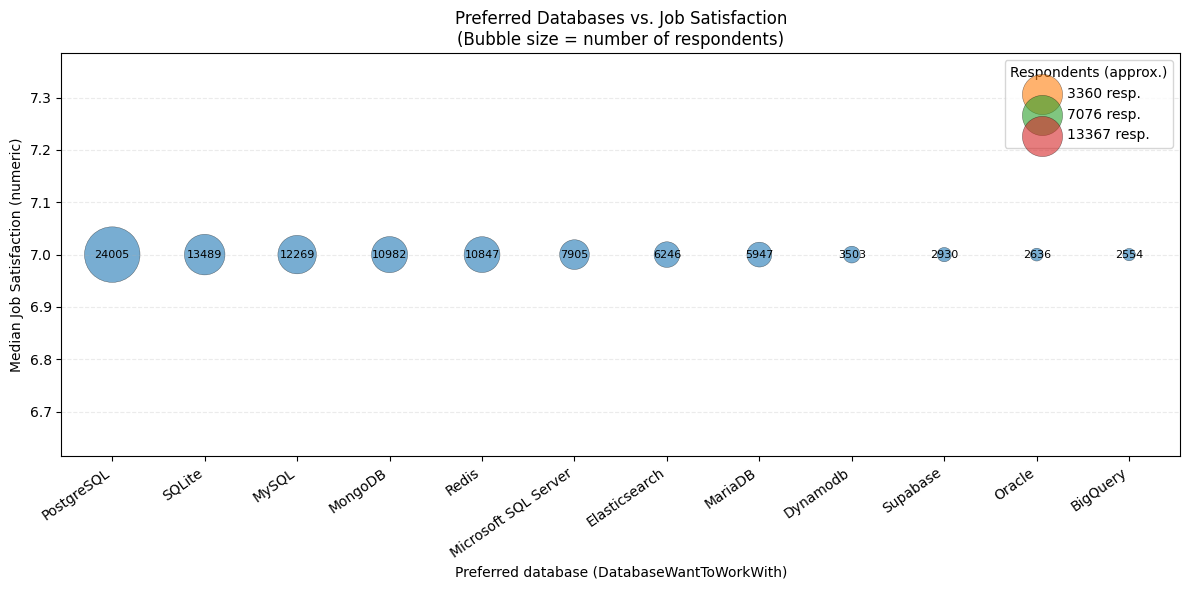

In [6]:
# --- 1) Prepare JobSat as numeric -------------------------------------------
def to_jobsat_numeric(x):
    # Try numeric first (e.g., 1–5 or 1–10)
    v = pd.to_numeric(x, errors="coerce")
    if pd.notna(v):
        return float(v)
    # Map common Likert text -> 1..5
    s = str(x).strip().lower()
    if s.startswith("very sat") or s.startswith("extremely sat"):
        return 5.0
    if s.startswith("slightly sat") or s.startswith("somewhat sat"):
        return 4.0
    if "neither" in s:
        return 3.0
    if s.startswith("slightly dis") or s.startswith("somewhat dis"):
        return 2.0
    if s.startswith("very dis") or s.startswith("extremely dis"):
        return 1.0
    return float("nan")

if "JobSat" not in df.columns:
    raise KeyError("Column 'JobSat' not found.")
df["JobSat_num"] = df["JobSat"].apply(to_jobsat_numeric)

# --- 2) Explode preferred databases (DatabaseWantToWorkWith) ----------------
if "DatabaseWantToWorkWith" not in df.columns:
    raise KeyError("Column 'DatabaseWantToWorkWith' not found.")

db_pref = (
    df[["DatabaseWantToWorkWith", "JobSat_num"]]
      .dropna(subset=["DatabaseWantToWorkWith"])  # keep rows with DB choices
      .copy()
)

# Split multi-select (handles ';' or ',' with optional spaces), then explode
db_pref["Database"] = db_pref["DatabaseWantToWorkWith"].str.split(r";\s*|,\s*")
db_pref = db_pref.explode("Database")
db_pref["Database"] = db_pref["Database"].str.strip()
db_pref = db_pref[db_pref["Database"].ne("")]

# --- 3) Aggregate: count respondents & median JobSat per database -----------
agg = (
    db_pref.groupby("Database", as_index=False)
           .agg(respondents=("Database", "size"),
                median_jobsat=("JobSat_num", "median"))
)

# Drop databases with no JobSat info
agg = agg.dropna(subset=["median_jobsat"])

# (Optional) limit to Top-N by respondents for readability
TOP_N = 12
agg = agg.sort_values("respondents", ascending=False)
top_keep = agg["Database"].head(TOP_N).tolist()
agg = agg[agg["Database"].isin(top_keep)].copy()

# --- 4) Scale bubble sizes from respondent counts ---------------------------
def scale_sizes(s, min_size=80, max_size=1600):
    s = s.astype(float)
    lo, hi = s.min(), s.max()
    if pd.isna(lo) or pd.isna(hi) or lo == hi:
        return pd.Series([(min_size + max_size) / 2.0] * len(s), index=s.index)
    return min_size + (s - lo) * (max_size - min_size) / (hi - lo)

agg = agg.sort_values("respondents", ascending=False).reset_index(drop=True)
agg["x"] = range(len(agg))
agg["size"] = scale_sizes(agg["respondents"], 80, 1600)

# --- 5) Plot: Bubble chart --------------------------------------------------
plt.figure(figsize=(12, 6))
plt.scatter(
    agg["x"], agg["median_jobsat"],
    s=agg["size"],
    alpha=0.6,
    edgecolors="black",
    linewidths=0.3
)

plt.xticks(agg["x"], agg["Database"], rotation=35, ha="right")
plt.ylabel("Median Job Satisfaction (numeric)")
plt.xlabel("Preferred database (DatabaseWantToWorkWith)")
plt.title("Preferred Databases vs. Job Satisfaction\n(Bubble size = number of respondents)")

# Optional: annotate bubbles with counts
for _, row in agg.iterrows():
    plt.text(row["x"], row["median_jobsat"], str(int(row["respondents"])),
             ha="center", va="center", fontsize=8)

# Build a small size legend based on quantiles of respondent counts
qvals = (
    agg["respondents"]
    .quantile([0.25, 0.5, 0.9])
    .round()
    .astype(int)
    .drop_duplicates()
    .tolist()
)
for v in qvals:
    plt.scatter([], [], s=scale_sizes(pd.Series([v]), 80, 1600).iloc[0],
                alpha=0.6, edgecolors="black", linewidths=0.3, label=f"{v} resp.")
plt.legend(title="Respondents (approx.)", scatterpoints=1, frameon=True, loc="upper right")

plt.grid(True, axis="y", linestyle="--", alpha=0.25)
plt.tight_layout()
plt.show()


### Task 3: Comparing Data Using Bubble Plots


#### 1. Bubble Plot for Compensation Across Developer Roles

- Visualize compensation (`ConvertedCompYearly`) across different developer roles (`DevType`).

- Use bubble size to represent job satisfaction.


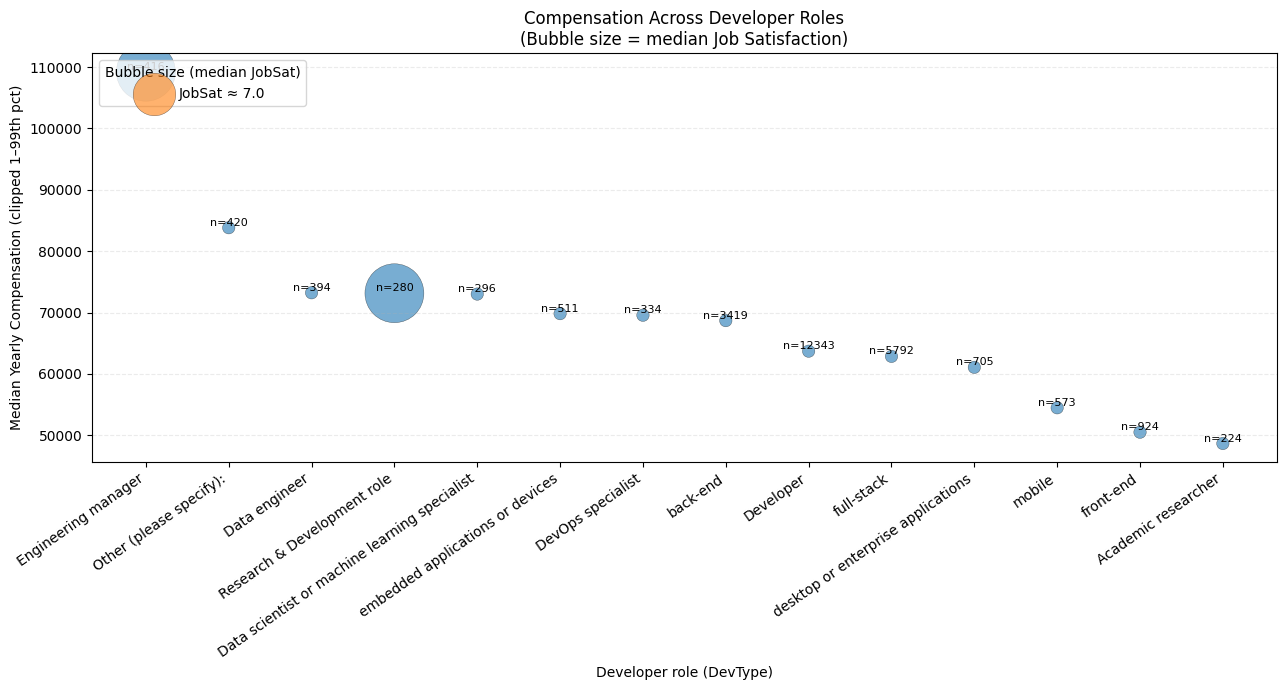

In [7]:
# Job satisfaction -> numeric
def to_jobsat_numeric(x):
    v = pd.to_numeric(x, errors="coerce")
    if pd.notna(v):
        return float(v)
    s = str(x).strip().lower()
    if s.startswith("very sat") or "extremely sat" in s:
        return 5.0
    if s.startswith("slightly sat") or "somewhat sat" in s:
        return 4.0
    if "neither" in s:
        return 3.0
    if s.startswith("slightly dis") or "somewhat dis" in s:
        return 2.0
    if s.startswith("very dis") or "extremely dis" in s:
        return 1.0
    return float("nan")

for col in ["ConvertedCompYearly", "DevType", "JobSat"]:
    if col not in df.columns:
        raise KeyError(f"Column '{col}' not found in the dataset.")

df["JobSat_num"] = df["JobSat"].apply(to_jobsat_numeric)
df["Comp_num"]   = pd.to_numeric(df["ConvertedCompYearly"], errors="coerce")

# Keep rows needed for this plot
base = df[["DevType", "Comp_num", "JobSat_num"]].dropna().copy()

# --- 2) Explode multi-select DevType ---------------------------------------
# Split by ';' or ',' then explode to one role per row
base["Role"] = base["DevType"].str.split(r";\s*|,\s*")
base = base.explode("Role")
base["Role"] = base["Role"].str.strip()
base = base[base["Role"].ne("")]

# --- 3) Aggregate by role ---------------------------------------------------
agg = (
    base.groupby("Role", as_index=False)
        .agg(
            respondents=("Role", "size"),
            median_comp=("Comp_num", "median"),
            median_jobsat=("JobSat_num", "median")
        )
)

# Remove rows without a valid median
agg = agg.dropna(subset=["median_comp", "median_jobsat"])

# Optional: reduce to Top-N roles by sample size for readability
TOP_N = 14
agg = agg.sort_values("respondents", ascending=False).head(TOP_N).copy()

# Clip compensation to 1st–99th pct to reduce extreme skew (for plotting)
lo, hi = agg["median_comp"].quantile([0.01, 0.99])
agg["median_comp_clipped"] = agg["median_comp"].clip(lower=lo, upper=hi)

# --- 4) Bubble sizes from JobSat (scale marker AREA) ------------------------
def scale_sizes(s, min_size=80, max_size=1800):
    s = pd.to_numeric(s, errors="coerce")
    lo, hi = s.min(), s.max()
    if pd.isna(lo) or pd.isna(hi) or lo == hi:
        return pd.Series([(min_size + max_size) / 2.0] * len(s), index=s.index)
    return min_size + (s - lo) * (max_size - min_size) / (hi - lo)

agg = agg.sort_values("median_comp_clipped", ascending=False).reset_index(drop=True)
agg["x"] = range(len(agg))
agg["size"] = scale_sizes(agg["median_jobsat"], 80, 1800)

# --- 5) Plot: Bubble chart --------------------------------------------------
plt.figure(figsize=(13, 7))
plt.scatter(
    agg["x"], agg["median_comp_clipped"],
    s=agg["size"],
    alpha=0.6,
    edgecolors="black",
    linewidths=0.3
)

plt.xticks(agg["x"], agg["Role"], rotation=35, ha="right")
plt.ylabel("Median Yearly Compensation (clipped 1–99th pct)")
plt.xlabel("Developer role (DevType)")
plt.title("Compensation Across Developer Roles\n(Bubble size = median Job Satisfaction)")

# Optional annotations: respondents per role
for _, row in agg.iterrows():
    plt.text(row["x"], row["median_comp_clipped"], f"n={int(row['respondents'])}",
             ha="center", va="bottom", fontsize=8)

# Size legend: example JobSat values
for js in sorted({round(agg["median_jobsat"].quantile(q), 1) for q in [0.2, 0.5, 0.8]}):
    plt.scatter([], [], s=scale_sizes(pd.Series([js]), 80, 1800).iloc[0],
                alpha=0.6, edgecolors="black", linewidths=0.3, label=f"JobSat ≈ {js}")
plt.legend(title="Bubble size (median JobSat)", scatterpoints=1, frameon=True, loc="upper left")

plt.grid(True, axis="y", linestyle="--", alpha=0.25)
plt.tight_layout()
plt.show()


#### 2. Bubble Plot for Collaboration Tools by Age

- Visualize the relationship between the collaboration tools used (`NEWCollabToolsHaveWorkedWith`) and age groups.

- Use bubble size to represent the frequency of tool usage.


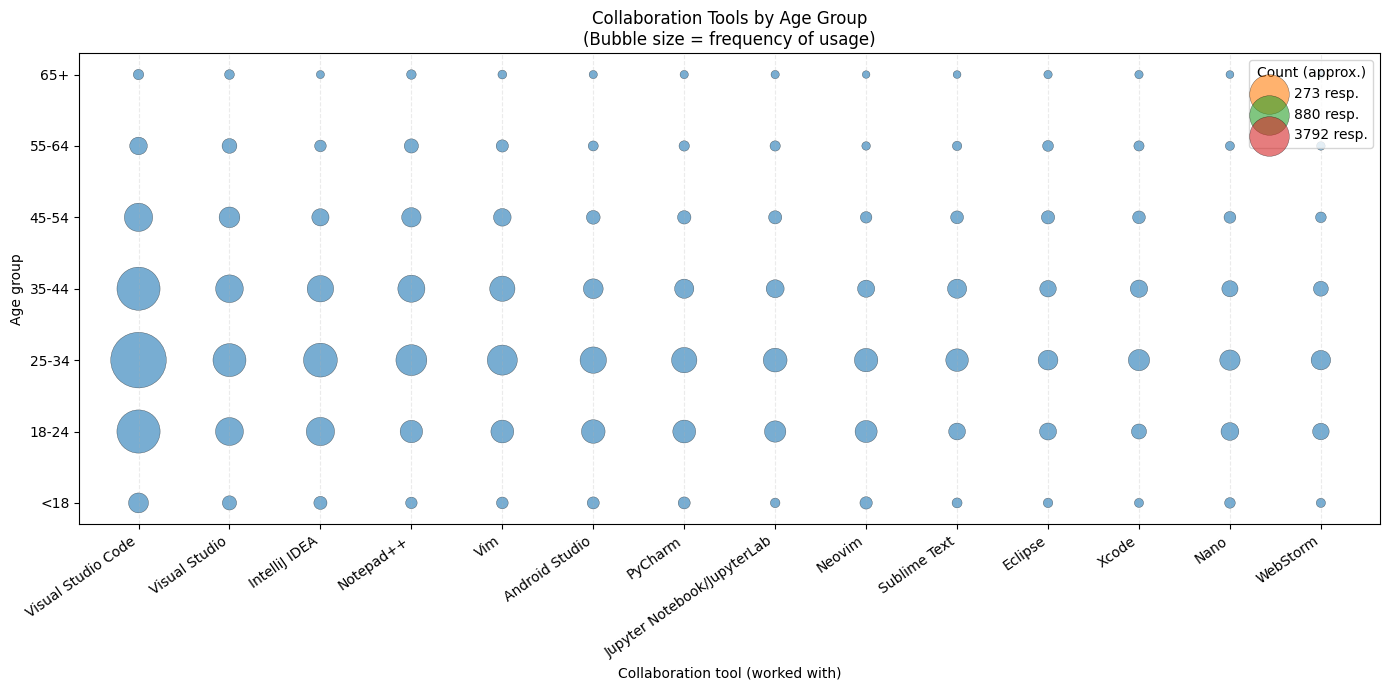

In [8]:
# --- 1) Prepare Age groups ---------------------------------------------------
age_labels = ["<18", "18-24", "25-34", "35-44", "45-54", "55-64", "65+"]

def to_age_group(x):
    if pd.isna(x):
        return pd.NA
    s = str(x).strip().lower()
    if "under 18" in s:
        return "<18"
    if "18-24" in s or ("18" in s and "24" in s):
        return "18-24"
    if "25-34" in s or ("25" in s and "34" in s):
        return "25-34"
    if "35-44" in s or ("35" in s and "44" in s):
        return "35-44"
    if "45-54" in s or ("45" in s and "54" in s):
        return "45-54"
    if "55-64" in s or ("55" in s and "64" in s):
        return "55-64"
    if "65" in s and ("older" in s or "+" in s or "or older" in s):
        return "65+"
    return pd.NA

if "Age" not in df.columns:
    raise KeyError("Column 'Age' not found.")
if "NEWCollabToolsHaveWorkedWith" not in df.columns:
    raise KeyError("Column 'NEWCollabToolsHaveWorkedWith' not found.")

work = df[["Age", "NEWCollabToolsHaveWorkedWith"]].dropna().copy()
work["AgeGroup"] = work["Age"].apply(to_age_group)
work = work.dropna(subset=["AgeGroup"])

# --- 2) Split multi-select tools and explode --------------------------------
# Handles separators like ';' or ',' with optional spaces
work["Tool"] = work["NEWCollabToolsHaveWorkedWith"].str.split(r";\s*|,\s*", regex=True)
work = work.explode("Tool")
work["Tool"] = work["Tool"].astype(str).str.strip()
work = work[work["Tool"].ne("")]

# Keep age as ordered categorical
work["AgeGroup"] = pd.Categorical(work["AgeGroup"], categories=age_labels, ordered=True)

# --- 3) Count frequency by AgeGroup x Tool ----------------------------------
counts = (
    work.groupby(["AgeGroup", "Tool"], observed=True)
        .size()
        .reset_index(name="freq")
)

# Optional: focus on Top-N tools overall for readability
TOP_N = 14
top_tools = counts.groupby("Tool")["freq"].sum().nlargest(TOP_N).index
counts = counts[counts["Tool"].isin(top_tools)].copy()

# Order axes
tool_order = (
    counts.groupby("Tool")["freq"].sum().sort_values(ascending=False).index.tolist()
)
counts["Tool"] = pd.Categorical(counts["Tool"], categories=tool_order, ordered=True)

# Map categories to axis positions
counts["x"] = counts["Tool"].cat.codes
counts["y"] = counts["AgeGroup"].cat.codes

# --- 4) Bubble sizes from frequency -----------------------------------------
def scale_sizes(s, min_size=30, max_size=1600):
    s = pd.to_numeric(s, errors="coerce")
    lo, hi = s.min(), s.max()
    if pd.isna(lo) or pd.isna(hi) or lo == hi:
        return pd.Series([ (min_size + max_size) / 2.0 ] * len(s), index=s.index)
    return min_size + (s - lo) * (max_size - min_size) / (hi - lo)

counts["size"] = scale_sizes(counts["freq"], 30, 1600)

# --- 5) Plot: Bubble chart ---------------------------------------------------
plt.figure(figsize=(14, 7))
plt.scatter(
    counts["x"], counts["y"],
    s=counts["size"],
    alpha=0.6,
    edgecolors="black",
    linewidths=0.3
)

# Ticks & labels
plt.xticks(range(len(tool_order)), tool_order, rotation=35, ha="right")
plt.yticks(range(len(age_labels)), age_labels)
plt.xlabel("Collaboration tool (worked with)")
plt.ylabel("Age group")
plt.title("Collaboration Tools by Age Group\n(Bubble size = frequency of usage)")

# Size legend using respondent-count quantiles
qvals = (
    counts["freq"]
    .quantile([0.25, 0.5, 0.9])
    .round()
    .astype(int)
    .drop_duplicates()
    .tolist()
)
for v in qvals:
    plt.scatter([], [], s=scale_sizes(pd.Series([v]), 30, 1600).iloc[0],
                alpha=0.6, edgecolors="black", linewidths=0.3, label=f"{v} resp.")
plt.legend(title="Count (approx.)", scatterpoints=1, frameon=True, loc="upper right")

plt.grid(True, axis="x", linestyle="--", alpha=0.25)
plt.tight_layout()
plt.show()


### Task 4: Visualizing Technology Trends Using Bubble Plots


#### 1. Bubble Plot for Preferred Web Frameworks vs. Job Satisfaction

- Explore the relationship between preferred web frameworks (`WebframeWantToWorkWith`) and job satisfaction.

- Use bubble size to represent the number of respondents.



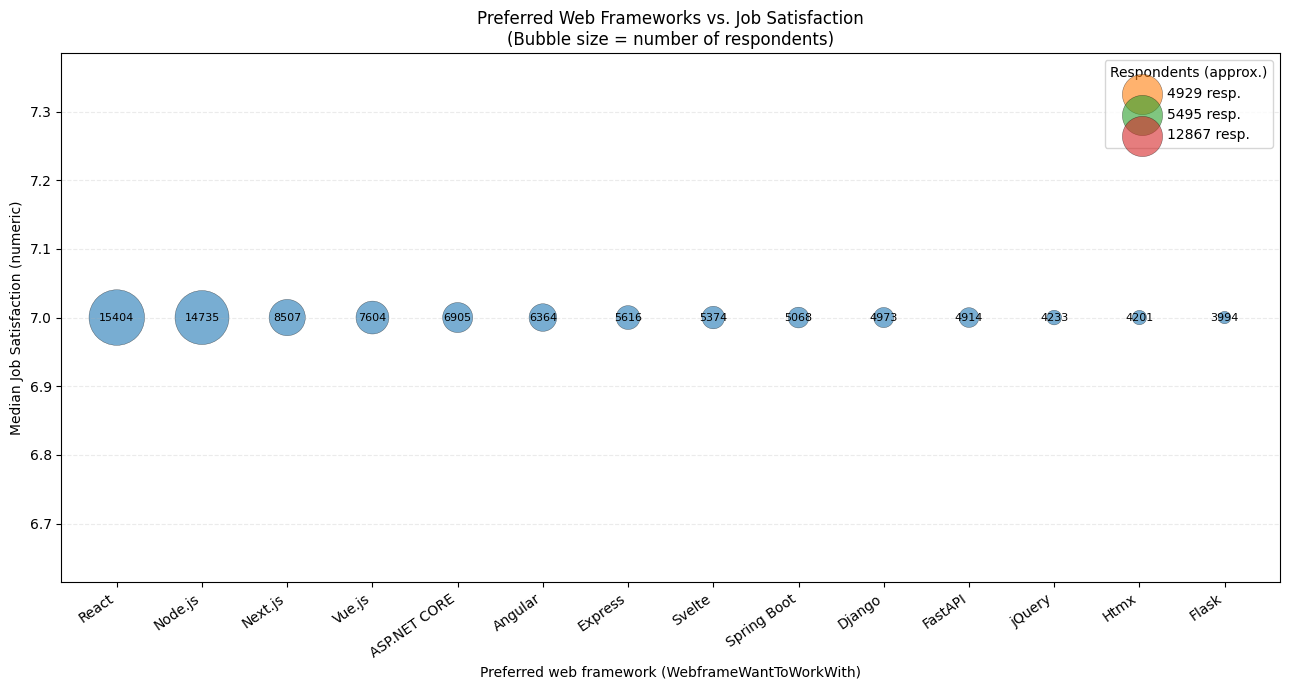

In [9]:
# --- 1) Prepare JobSat as numeric -------------------------------------------
def to_jobsat_numeric(x):
    # Try numeric first (e.g., 1–5 or 1–10)
    v = pd.to_numeric(x, errors="coerce")
    if pd.notna(v):
        return float(v)
    # Map common Likert text -> 1..5
    s = str(x).strip().lower()
    if s.startswith("very sat") or "extremely sat" in s:
        return 5.0
    if s.startswith("slightly sat") or "somewhat sat" in s:
        return 4.0
    if "neither" in s:
        return 3.0
    if s.startswith("slightly dis") or "somewhat dis" in s:
        return 2.0
    if s.startswith("very dis") or "extremely dis" in s:
        return 1.0
    return float("nan")

if "JobSat" not in df.columns:
    raise KeyError("Column 'JobSat' not found.")
df["JobSat_num"] = df["JobSat"].apply(to_jobsat_numeric)

# --- 2) Explode preferred web frameworks ------------------------------------
col = "WebframeWantToWorkWith"
if col not in df.columns:
    raise KeyError(f"Column '{col}' not found.")

wf = (
    df[[col, "JobSat_num"]]
      .dropna(subset=[col])  # need framework choices
      .copy()
)

# Split multi-select (handles ';' or ',' with optional spaces), then explode
wf["Framework"] = wf[col].str.split(r";\s*|,\s*")
wf = wf.explode("Framework")
wf["Framework"] = wf["Framework"].astype(str).str.strip()
wf = wf[wf["Framework"].ne("")]

# --- 3) Aggregate: count respondents & median JobSat per framework ----------
agg = (
    wf.groupby("Framework", as_index=False)
      .agg(
          respondents=("Framework", "size"),
          median_jobsat=("JobSat_num", "median")
      )
)

# Drop frameworks with no JobSat info
agg = agg.dropna(subset=["median_jobsat"])

# (Optional) limit to Top-N by respondents for readability
TOP_N = 14
agg = agg.sort_values("respondents", ascending=False)
top_keep = agg["Framework"].head(TOP_N).tolist()
agg = agg[agg["Framework"].isin(top_keep)].copy()

# --- 4) Scale bubble sizes from respondent counts ---------------------------
def scale_sizes(s, min_size=80, max_size=1600):
    s = pd.to_numeric(s, errors="coerce")
    lo, hi = s.min(), s.max()
    if pd.isna(lo) or pd.isna(hi) or lo == hi:
        return pd.Series([(min_size + max_size) / 2.0] * len(s), index=s.index)
    return min_size + (s - lo) * (max_size - min_size) / (hi - lo)

agg = agg.sort_values("respondents", ascending=False).reset_index(drop=True)
agg["x"] = range(len(agg))
agg["size"] = scale_sizes(agg["respondents"], 80, 1600)

# --- 5) Plot: Bubble chart --------------------------------------------------
plt.figure(figsize=(13, 7))
plt.scatter(
    agg["x"], agg["median_jobsat"],
    s=agg["size"],
    alpha=0.6,
    edgecolors="black",
    linewidths=0.3
)

plt.xticks(agg["x"], agg["Framework"], rotation=35, ha="right")
plt.ylabel("Median Job Satisfaction (numeric)")
plt.xlabel("Preferred web framework (WebframeWantToWorkWith)")
plt.title("Preferred Web Frameworks vs. Job Satisfaction\n(Bubble size = number of respondents)")

# Optional: annotate bubbles with counts
for _, row in agg.iterrows():
    plt.text(row["x"], row["median_jobsat"], str(int(row["respondents"])),
             ha="center", va="center", fontsize=8)

# Size legend based on quantiles of respondent counts
qvals = (
    agg["respondents"]
    .quantile([0.25, 0.5, 0.9])
    .round()
    .astype(int)
    .drop_duplicates()
    .tolist()
)
for v in qvals:
    plt.scatter([], [], s=scale_sizes(pd.Series([v]), 80, 1600).iloc[0],
                alpha=0.6, edgecolors="black", linewidths=0.3, label=f"{v} resp.")
plt.legend(title="Respondents (approx.)", scatterpoints=1, frameon=True, loc="upper right")

plt.grid(True, axis="y", linestyle="--", alpha=0.25)
plt.tight_layout()
plt.show()


#### 2. Bubble Plot for Admired Technologies Across Countries

- Visualize the distribution of admired technologies (`LanguageAdmired`) across different countries (`Country`).

- Use bubble size to represent the frequency of admiration.



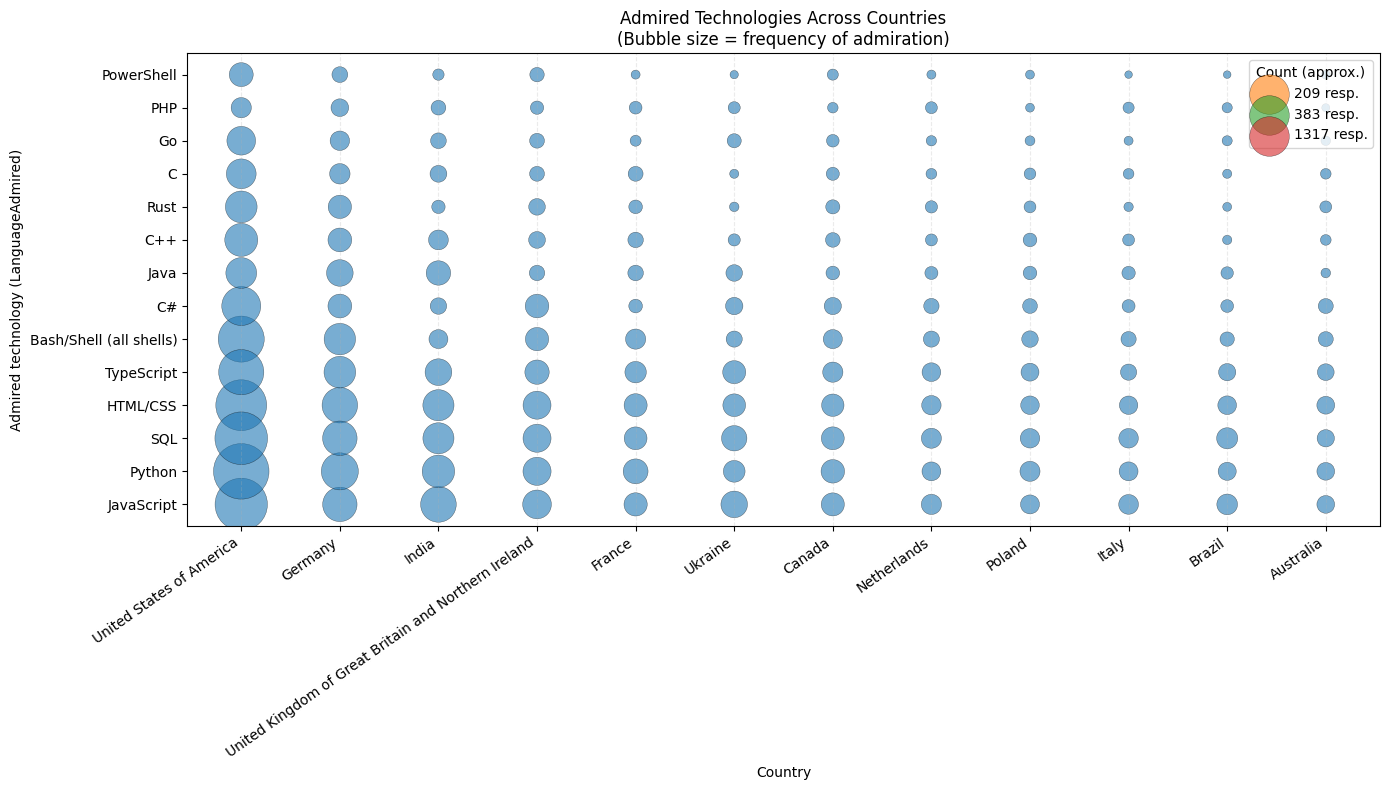

In [10]:
# --- 1) Validate columns -----------------------------------------------------
if "LanguageAdmired" not in df.columns:
    raise KeyError("Column 'LanguageAdmired' not found in the dataset.")
if "Country" not in df.columns:
    raise KeyError("Column 'Country' not found in the dataset.")

# --- 2) Prep and explode admired technologies -------------------------------
adm = (
    df[["Country", "LanguageAdmired"]]
      .dropna(subset=["Country", "LanguageAdmired"])
      .copy()
)

# Split multi-select (handles ';' or ',' with optional spaces), then explode
adm["Tech"] = adm["LanguageAdmired"].str.split(r";\s*|,\s*")
adm = adm.explode("Tech")
adm["Tech"] = adm["Tech"].astype(str).str.strip()
adm = adm[adm["Tech"].ne("")]

# --- 3) Count frequency by Country x Tech -----------------------------------
counts = (
    adm.groupby(["Country", "Tech"], observed=True)
       .size()
       .reset_index(name="freq")
)

# --- 4) (Optional) limit to Top-N for readability ---------------------------
TOP_COUNTRIES = 12
TOP_TECHS     = 14

top_countries = counts.groupby("Country")["freq"].sum().nlargest(TOP_COUNTRIES).index
top_techs     = counts.groupby("Tech")["freq"].sum().nlargest(TOP_TECHS).index

counts = counts[counts["Country"].isin(top_countries) & counts["Tech"].isin(top_techs)].copy()

# Order axes by overall frequency
country_order = (
    counts.groupby("Country")["freq"].sum().sort_values(ascending=False).index.tolist()
)
tech_order = (
    counts.groupby("Tech")["freq"].sum().sort_values(ascending=False).index.tolist()
)

counts["Country"] = pd.Categorical(counts["Country"], categories=country_order, ordered=True)
counts["Tech"]    = pd.Categorical(counts["Tech"],    categories=tech_order,    ordered=True)

# Map categories to axis positions
counts["x"] = counts["Country"].cat.codes
counts["y"] = counts["Tech"].cat.codes

# --- 5) Bubble sizes from frequency -----------------------------------------
def scale_sizes(s, min_size=30, max_size=1600):
    s = pd.to_numeric(s, errors="coerce")
    lo, hi = s.min(), s.max()
    if pd.isna(lo) or pd.isna(hi) or lo == hi:
        return pd.Series([ (min_size + max_size) / 2.0 ] * len(s), index=s.index)
    return min_size + (s - lo) * (max_size - min_size) / (hi - lo)

counts["size"] = scale_sizes(counts["freq"], 30, 1600)

# --- 6) Plot: Bubble chart ---------------------------------------------------
plt.figure(figsize=(14, 8))
plt.scatter(
    counts["x"], counts["y"],
    s=counts["size"],
    alpha=0.6,
    edgecolors="black",
    linewidths=0.3
)

# Ticks & labels
plt.xticks(range(len(country_order)), country_order, rotation=35, ha="right")
plt.yticks(range(len(tech_order)), tech_order)
plt.xlabel("Country")
plt.ylabel("Admired technology (LanguageAdmired)")
plt.title("Admired Technologies Across Countries\n(Bubble size = frequency of admiration)")

# Size legend using quantiles of counts
qvals = (
    counts["freq"]
    .quantile([0.25, 0.5, 0.9])
    .round()
    .astype(int)
    .drop_duplicates()
    .tolist()
)
for v in qvals:
    plt.scatter([], [], s=scale_sizes(pd.Series([v]), 30, 1600).iloc[0],
                alpha=0.6, edgecolors="black", linewidths=0.3, label=f"{v} resp.")
plt.legend(title="Count (approx.)", scatterpoints=1, frameon=True, loc="upper right")

plt.grid(True, axis="x", linestyle="--", alpha=0.25)
plt.tight_layout()
plt.show()


## Final Step: Review


After completing the lab, you will have extensively used bubble plots to gain insights into developer community preferences, demographics, compensation trends, and job satisfaction.


In this lab I used bubble plots to explore developer preferences, demographics, compensation, and job satisfaction. I cleaned and standardized key fields (e.g., parsing age groups, exploding multi-select columns, mapping JobSat to numeric), then aggregated by meaningful categories. Across charts, circle **position** compared categories (e.g., Age group × SOPartFreq, Role, Country, Tools), **size** encoded frequency or JobSat, and compensation was clipped to reduce outlier skew (log scale where helpful).

Key takeaways:

* **Community preferences:** Clear clusters show which languages, databases, web frameworks, and collaboration tools are most popular overall and within specific age bands.
* **Engagement patterns:** Participation frequency varies by age group, with younger cohorts generally engaging more often.
* **Compensation:** Median pay differs significantly across developer roles and preferred stacks; roles with higher medians often correlate with slightly higher satisfaction.
* **Satisfaction:** Bubble sizes/medians highlight which technologies and roles are associated with higher JobSat.

Limitations: self-reported data, missing values, varying sample sizes per segment, and medians that hide within-group spread.

Next steps: add CIs/error bars, normalize by country size, test differences statistically, and build an interactive dashboard for drill-downs.

### Quick checklist

* [x] Cleaned/typed fields (Age, JobSat, compensation)
* [x] Split multi-select columns and aggregated counts/medians
* [x] Scaled bubble areas consistently; annotated legends
* [x] Managed outliers (clipping/log scale)
* [x] Labeled axes/titles clearly; added readable ordering and rotations

## Summary


After completing this lab, you will be able to:

- Create and interpret bubble plots to analyze relationships and compositions within datasets.

- Use bubble plots to explore developer preferences, compensation trends, and satisfaction levels.

- Apply bubble plots to visualize complex relationships involving multiple dimensions effectively.


## Authors:
Ayushi Jain


### Other Contributors:
- Rav Ahuja
- Lakshmi Holla
- Malika


<!--
## Change Log
|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|
|2024-10-29|1.2|Madhusudhan Moole|Updated lab|
|2024-10-16|1.1|Madhusudhan Moole|Updated lab|
|2024-10-15|1.0|Raghul Ramesh|Created lab|
--!>


Copyright © IBM Corporation. All rights reserved.
